In [5]:
import pandas as pd
import os

# Define the data folder path
data_folder = 'data'

# 1. Load the datasets
# Adjust the filenames if they differ in your specific folder
successful_runs = pd.read_csv(os.path.join(data_folder, 'successful_runs.csv'))
xcfa_metrics = pd.read_csv(os.path.join(data_folder, 'xcfa_analysis_metrics.csv'))
log_iterations = pd.read_csv(os.path.join(data_folder, 'log_analysis_iterations.csv'))

# 2. Data Cleaning
# Remove 's' from CPU Time and 'B' from Memory, then convert to float
successful_runs['CPU Time'] = successful_runs['CPU Time'].astype(str).str.replace('s', '', regex=False).astype(float)
successful_runs['Memory'] = successful_runs['Memory'].astype(str).str.replace('B', '', regex=False).astype(float)

# Rename columns to ensure they match for merging
xcfa_metrics = xcfa_metrics.rename(columns={'Name': 'Filename'})
log_iterations = log_iterations.rename(columns={'Input Filename': 'Filename'})

# 3. Merging Dataframes
# Merge successful runs with XCFA size metrics (Variable Count, Locs, Edges, Atomic Stmts)
# We use 'inner' join to keep only files that exist in both datasets
merged_df = pd.merge(successful_runs, 
                     xcfa_metrics[['Filename', 'Variable Count', 'Locs', 'Edges', 'Atomic Stmts']], 
                     on='Filename', 
                     how='inner')

# Merge the result with Iterations data
# We join on Filename, Input Type, and Algorithm to ensure we match the specific run
final_df = pd.merge(merged_df, 
                    log_iterations[['Filename', 'Input Type', 'Algorithm', 'Iterations']], 
                    on=['Filename', 'Input Type', 'Algorithm'], 
                    how='inner')

# 4. Correlation Analysis
# Group by Input Type and Algorithm to calculate correlations for each configuration separately
groups = final_df.groupby(['Input Type', 'Algorithm'])

summary_data = []

print("Detailed Correlation Matrices per Group:\n")

for name, group in groups:
    input_type, algorithm = name
    
    # Columns to include in the correlation matrix
    # Performance metrics: CPU Time, Memory
    # Structural/Complexity metrics: Variable Count, Locs, Edges, Atomic Stmts, Iterations
    cols_to_correlate = ['CPU Time', 'Memory', 'Variable Count', 'Locs', 'Edges', 'Atomic Stmts', 'Iterations']
    
    # Calculate the correlation matrix
    corr_matrix = group[cols_to_correlate].corr()
    
    # Print the matrix for the current group
    print(f"--- Group: Input={input_type}, Algo={algorithm} ---")
    print(corr_matrix)
    print("-" * 40)
    
    # Collect summary data for a cleaner final table
    row = {
        'Input Type': input_type,
        'Algorithm': algorithm
    }
    
    # Extract specific correlations: Performance vs. Size/Iterations
    target_metrics = ['Variable Count', 'Locs', 'Edges', 'Atomic Stmts', 'Iterations']
    for metric in target_metrics:
        row[f'CPU_vs_{metric}'] = corr_matrix.loc['CPU Time', metric]
        row[f'Memory_vs_{metric}'] = corr_matrix.loc['Memory', metric]
        
    summary_data.append(row)

# 5. Display Summary DataFrame
summary_df = pd.DataFrame(summary_data)
print("\nCorrelation Summary Table:")
display(summary_df) # Use display() for nice formatting in Jupyter, or print() otherwise

Detailed Correlation Matrices per Group:

--- Group: Input=BTOR2, Algo=BMC ---
                CPU Time    Memory  Variable Count      Locs     Edges  \
CPU Time        1.000000  0.320855       -0.129812 -0.003002 -0.034838   
Memory          0.320855  1.000000        0.479498 -0.031027 -0.090709   
Variable Count -0.129812  0.479498        1.000000  0.546337  0.449723   
Locs           -0.003002 -0.031027        0.546337  1.000000  0.943008   
Edges          -0.034838 -0.090709        0.449723  0.943008  1.000000   
Atomic Stmts   -0.097590  0.384254        0.979704  0.665001  0.570011   
Iterations      0.050703 -0.398914       -0.503861  0.057749  0.292659   

                Atomic Stmts  Iterations  
CPU Time           -0.097590    0.050703  
Memory              0.384254   -0.398914  
Variable Count      0.979704   -0.503861  
Locs                0.665001    0.057749  
Edges               0.570011    0.292659  
Atomic Stmts        1.000000   -0.403894  
Iterations         -0.40389

,Input Type,Algorithm,CPU_vs_Variable Count,Memory_vs_Variable Count,CPU_vs_Locs,Memory_vs_Locs,CPU_vs_Edges,Memory_vs_Edges,CPU_vs_Atomic Stmts,Memory_vs_Atomic Stmts,CPU_vs_Iterations,Memory_vs_Iterations
0,BTOR2,BMC,-0.129812,0.479498,-3.001791e-03,-3.102705e-02,-3.483764e-02,-9.070898e-02,-0.097590,0.384254,0.050703,-0.398914
1,BTOR2,CEGAR_EXPL,0.391224,0.428847,-2.142622e-02,-6.529078e-02,-2.142622e-02,-6.529078e-02,0.295575,0.318055,0.236541,0.179375
2,BTOR2,CEGAR_PRED,0.271154,0.199758,-3.559027e-02,-4.538364e-02,-4.894211e-02,-6.042235e-02,0.199402,0.125798,0.278901,0.129300
3,BTOR2,IMC,0.114183,0.353871,-4.945505e-02,-1.995261e-02,-4.945505e-02,-1.995261e-02,0.083558,0.278851,0.160668,-0.037968
4,BTOR2,K-Induction,-0.132826,0.570780,-8.082551e-04,-3.234652e-02,-2.611463e-02,-7.422945e-02,-0.103124,0.460861,0.128398,-0.305549
5,C,BMC,0.819139,0.884486,-3.874210e-02,-3.008335e-02,-1.595909e-01,-1.239228e-01,0.730935,0.788956,-0.502550,-0.678299
6,C,CEGAR_EXPL,0.824212,0.830772,-4.667627e-02,-4.435939e-02,-1.922742e-01,-1.827303e-01,0.718525,0.723895,-0.696046,-0.691163
7,C,CEGAR_PRED,0.551617,0.757411,-1.752930e-01,-2.834937e-01,-2.117265e-01,-3.275796e-01,0.367861,0.466305,-0.177935,-0.397021
8,C,IMC,0.642830,0.149295,-8.174322e-18,1.639024e-17,-8.174322e-18,-2.731707e-17,0.539279,0.128296,-0.368374,-0.104263
9,C,K-Induction,0.580076,0.696349,-1.670550e-02,-2.778852e-02,-8.300177e-02,-1.380681e-01,0.497271,0.597427,-0.335898,-0.627861


Generating Correlation Matrix for BTOR2...


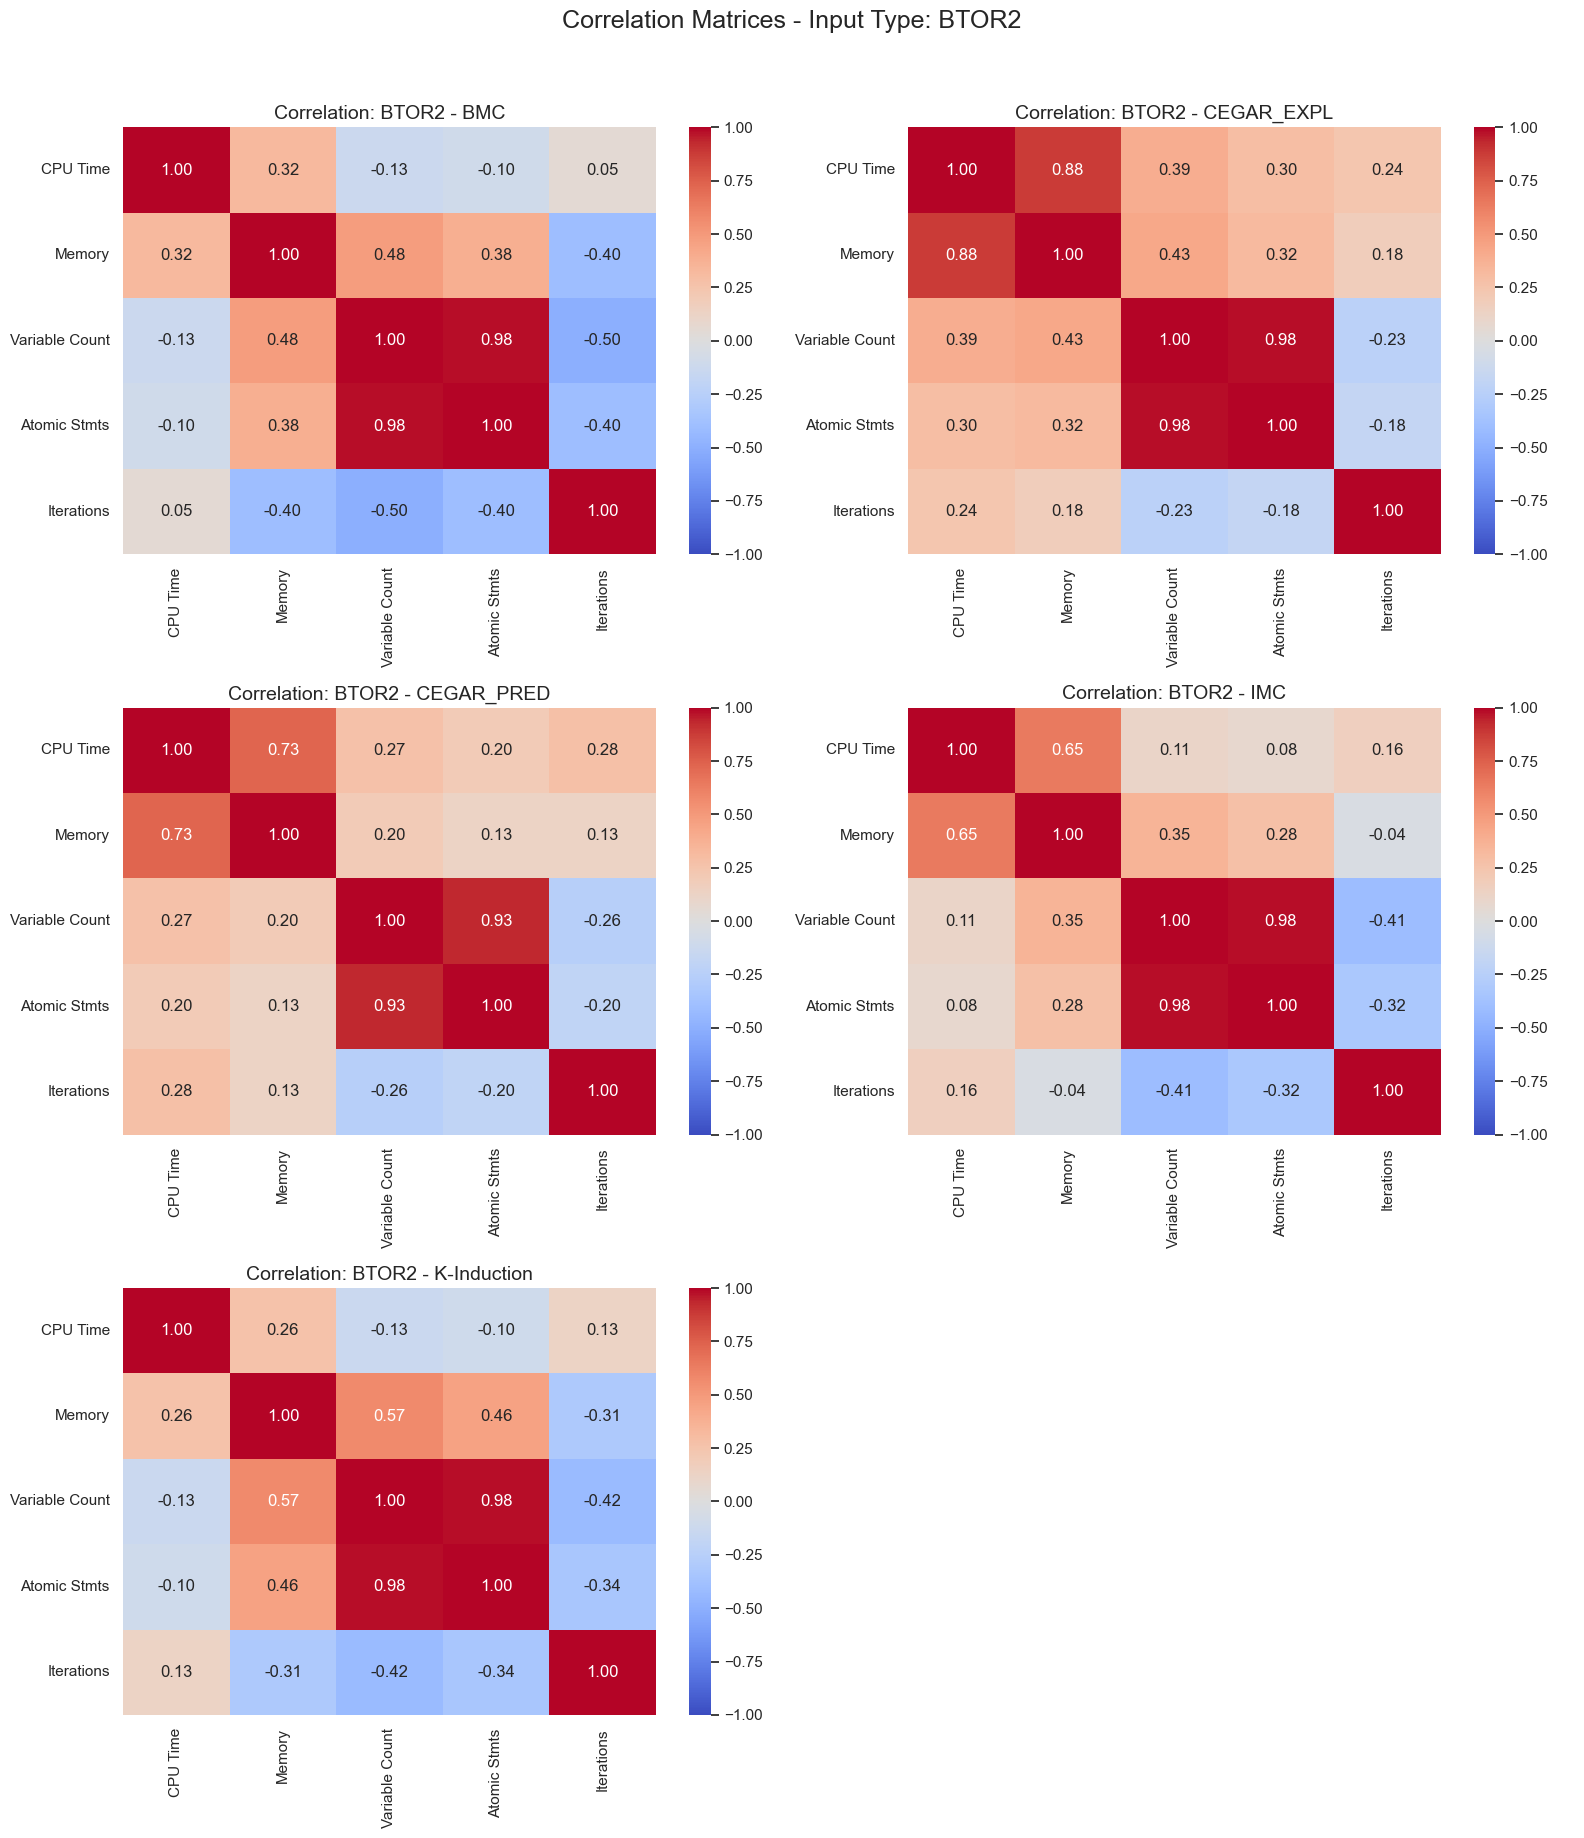

Generating Correlation Matrix for C...


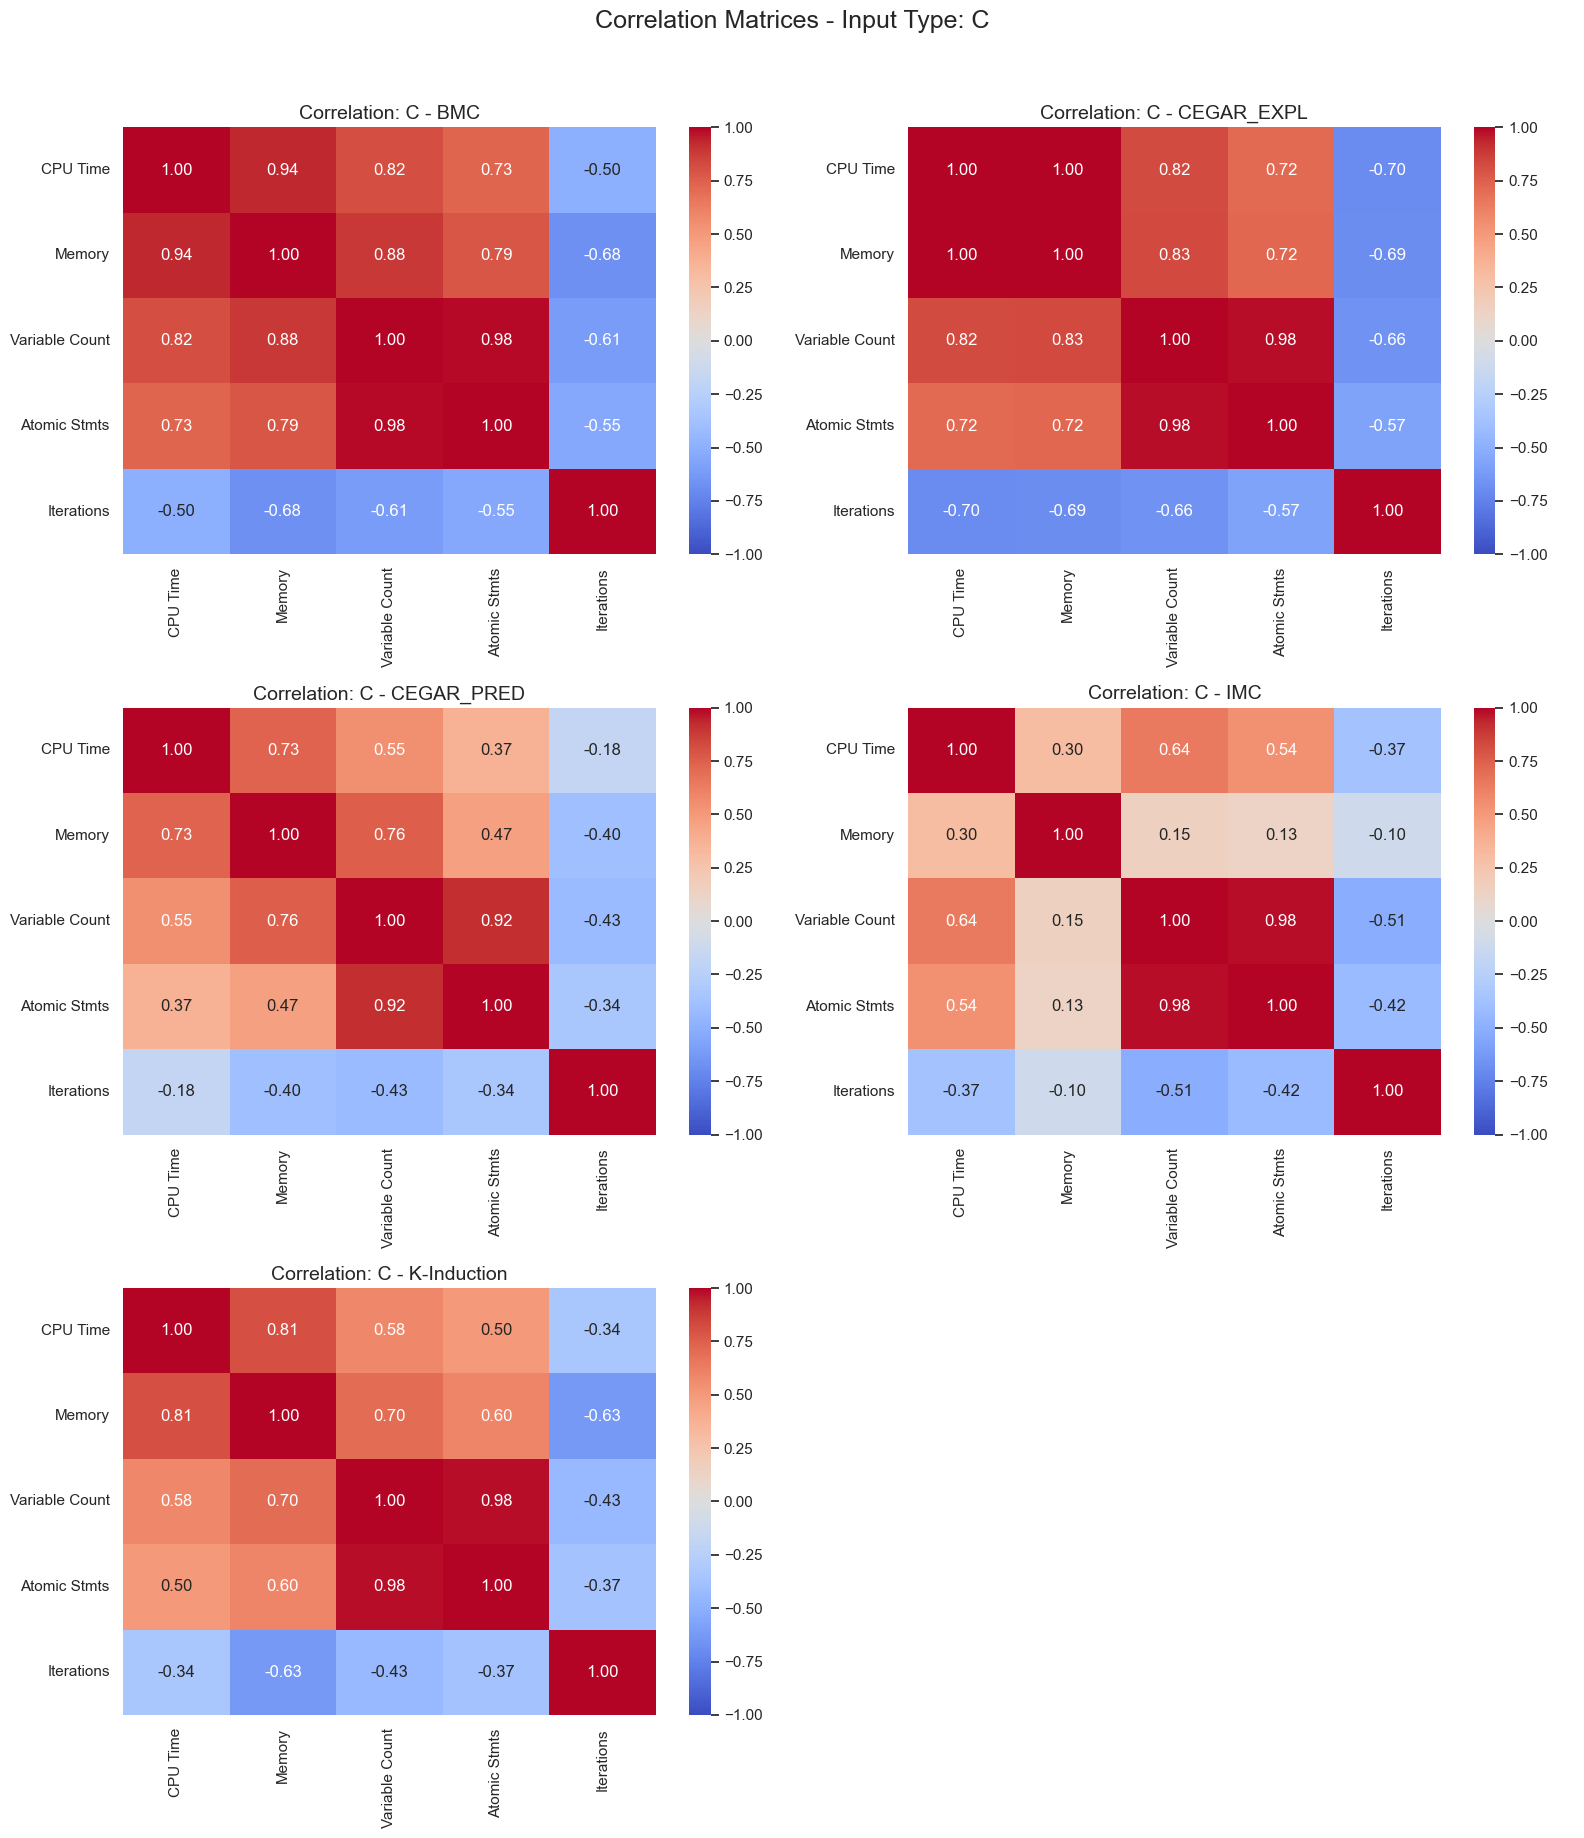

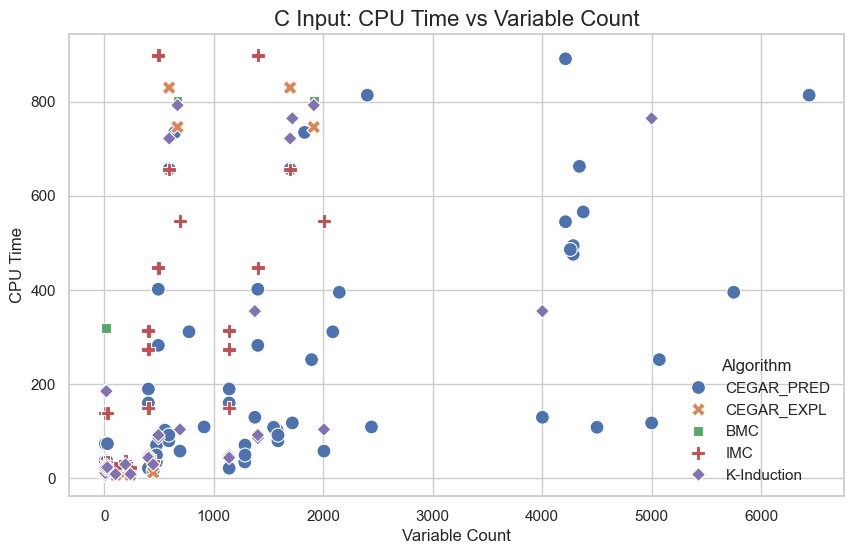

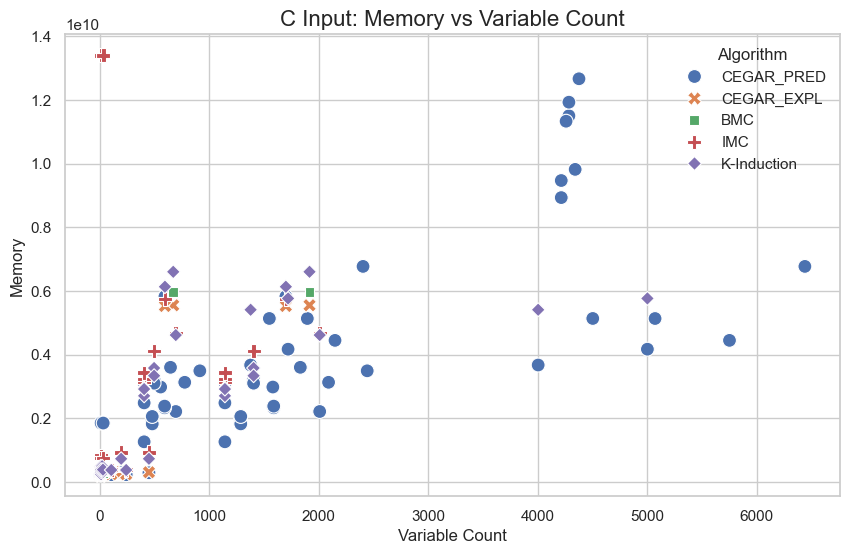

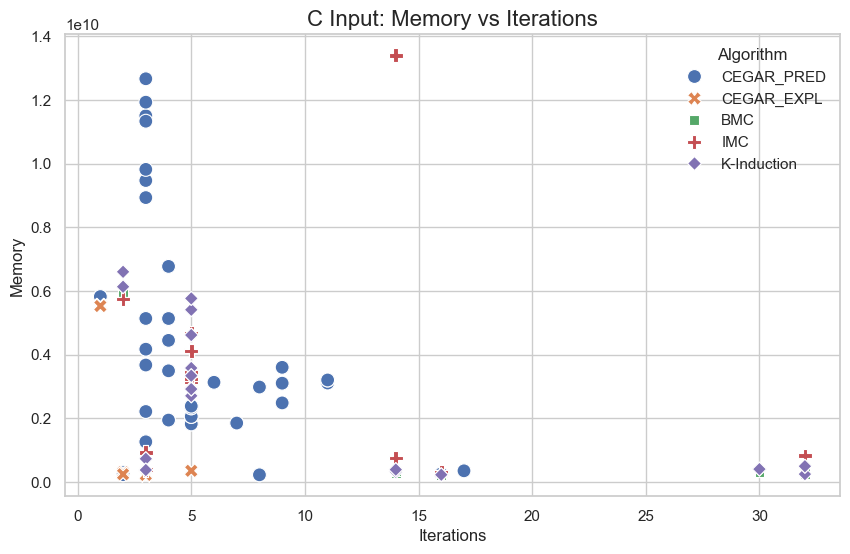

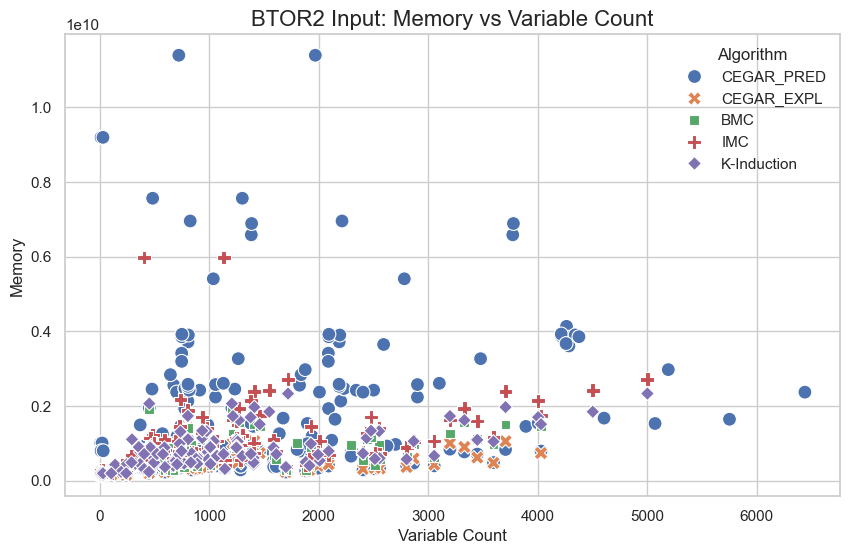

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# NOTE: If 'final_df' is not in memory from the previous block, 
# uncomment the lines below to reload and prepare the data:
# ------------------------------------------------------------------
# successful_runs = pd.read_csv('data/successful_runs.csv')
# xcfa_metrics = pd.read_csv('data/xcfa_analysis_metrics.csv')
# log_iterations = pd.read_csv('data/log_analysis_iterations.csv')
# successful_runs['CPU Time'] = successful_runs['CPU Time'].astype(str).str.replace('s', '', regex=False).astype(float)
# successful_runs['Memory'] = successful_runs['Memory'].astype(str).str.replace('B', '', regex=False).astype(float)
# xcfa_metrics = xcfa_metrics.rename(columns={'Name': 'Filename'})
# log_iterations = log_iterations.rename(columns={'Input Filename': 'Filename'})
# merged_df = pd.merge(successful_runs, xcfa_metrics[['Filename', 'Variable Count', 'Locs', 'Edges', 'Atomic Stmts']], on='Filename', how='inner')
# final_df = pd.merge(merged_df, log_iterations[['Filename', 'Input Type', 'Algorithm', 'Iterations']], on=['Filename', 'Input Type', 'Algorithm'], how='inner')
# ------------------------------------------------------------------

# Set the style for the plots
sns.set_theme(style="whitegrid")

# Metrics to include in the correlation
metrics = ['CPU Time', 'Memory', 'Variable Count', 'Atomic Stmts', 'Iterations']

# Helper function to generate and save heatmap grids
def create_heatmap_grid(input_type_name, df_subset):
    print(f"Generating Correlation Matrix for {input_type_name}...")
    
    # Group by Algorithm
    groups = df_subset.groupby('Algorithm')
    num_groups = len(groups)
    
    # Setup grid
    cols = 2
    rows = (num_groups + 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
    axes = axes.flatten()
    
    # Loop through each algorithm in this input type
    for i, (algo, group) in enumerate(groups):
        # Calculate correlation
        corr = group[metrics].corr()
        
        # Plot heatmap
        sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, ax=axes[i], cbar=True)
        axes[i].set_title(f'Correlation: {input_type_name} - {algo}', fontsize=14)
    
    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.suptitle(f"Correlation Matrices - Input Type: {input_type_name}", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

# 1. Generate Heatmaps for BTOR2
# ------------------------------------------------------------------
df_btor2 = final_df[final_df['Input Type'] == 'BTOR2']
if not df_btor2.empty:
    create_heatmap_grid("BTOR2", df_btor2)
else:
    print("No BTOR2 data found.")

# 2. Generate Heatmaps for C
# ------------------------------------------------------------------
df_c = final_df[final_df['Input Type'] == 'C']
if not df_c.empty:
    create_heatmap_grid("C", df_c)
else:
    print("No C data found.")

# 3. Scatter Plots for Input Type 'C' (Strongest Correlations)
# ------------------------------------------------------------------
# (Kept from original request as they are valuable for 'C')
if not df_c.empty:
    # 3a. CPU Time vs Variable Count
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_c, x='Variable Count', y='CPU Time', hue='Algorithm', style='Algorithm', s=100)
    plt.title('C Input: CPU Time vs Variable Count', fontsize=16)
    plt.show()

    # 3b. Memory vs Variable Count
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_c, x='Variable Count', y='Memory', hue='Algorithm', style='Algorithm', s=100)
    plt.title('C Input: Memory vs Variable Count', fontsize=16)
    plt.show()

    # 3c. Memory vs Iterations
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_c, x='Iterations', y='Memory', hue='Algorithm', style='Algorithm', s=100)
    plt.title('C Input: Memory vs Iterations', fontsize=16)
    plt.show()

# 4. Scatter Plots for Input Type 'BTOR2'
# ------------------------------------------------------------------
if not df_btor2.empty:
    # 4a. Memory vs Variable Count
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_btor2, x='Variable Count', y='Memory', hue='Algorithm', style='Algorithm', s=100)
    plt.title('BTOR2 Input: Memory vs Variable Count', fontsize=16)
    plt.show()

Loading datasets...
Iterations dataset shape: (6970, 4)
Results dataset shape: (383, 6)

First few rows of iterations dataset:
                    Input Filename Input Type Algorithm  Iterations
0  adding.1.prop1-back-serstep.yml      BTOR2       BMC           8
1   adding.1.prop1-func-interl.yml      BTOR2       BMC          15
2  adding.2.prop1-back-serstep.yml      BTOR2       BMC          10
3   adding.2.prop1-func-interl.yml      BTOR2       BMC          15
4  adding.3.prop1-back-serstep.yml      BTOR2       BMC          10

First few rows of results dataset:
                            Filename Input Type   Algorithm        CPU Time  \
0  anderson.1.prop1-back-serstep.yml      BTOR2  CEGAR_PRED   22.185776647s   
1  anderson.3.prop1-back-serstep.yml      BTOR2  CEGAR_PRED   82.704183111s   
2  anderson.5.prop1-back-serstep.yml      BTOR2  CEGAR_PRED  450.844758109s   
3  anderson.7.prop1-back-serstep.yml      BTOR2  CEGAR_PRED  750.928448566s   
4    bakery.2.prop1-back-serstep.y

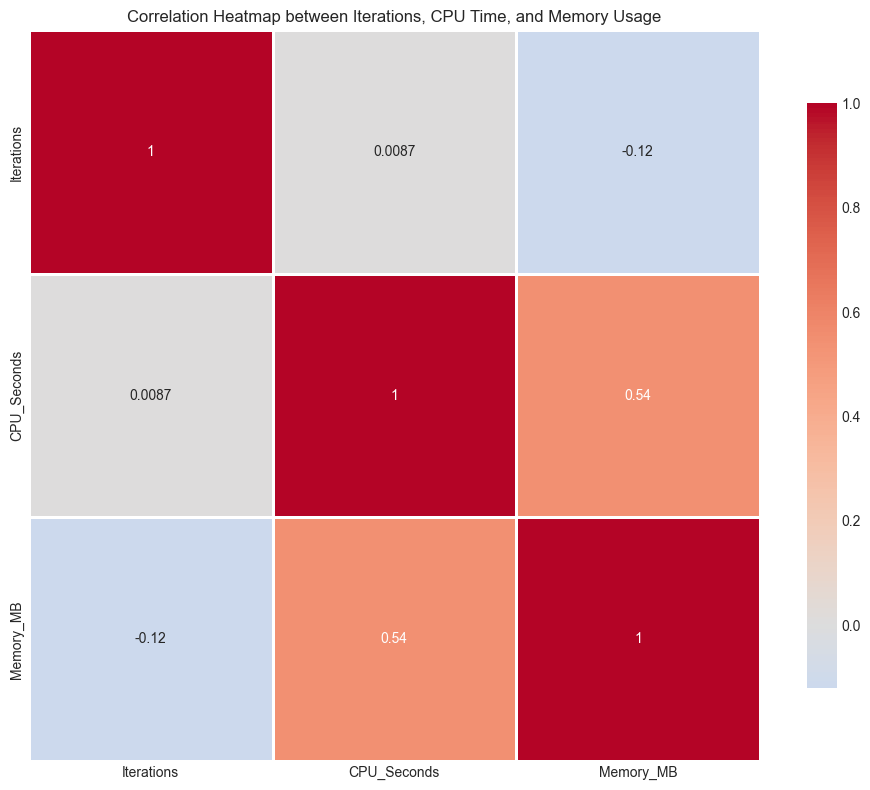

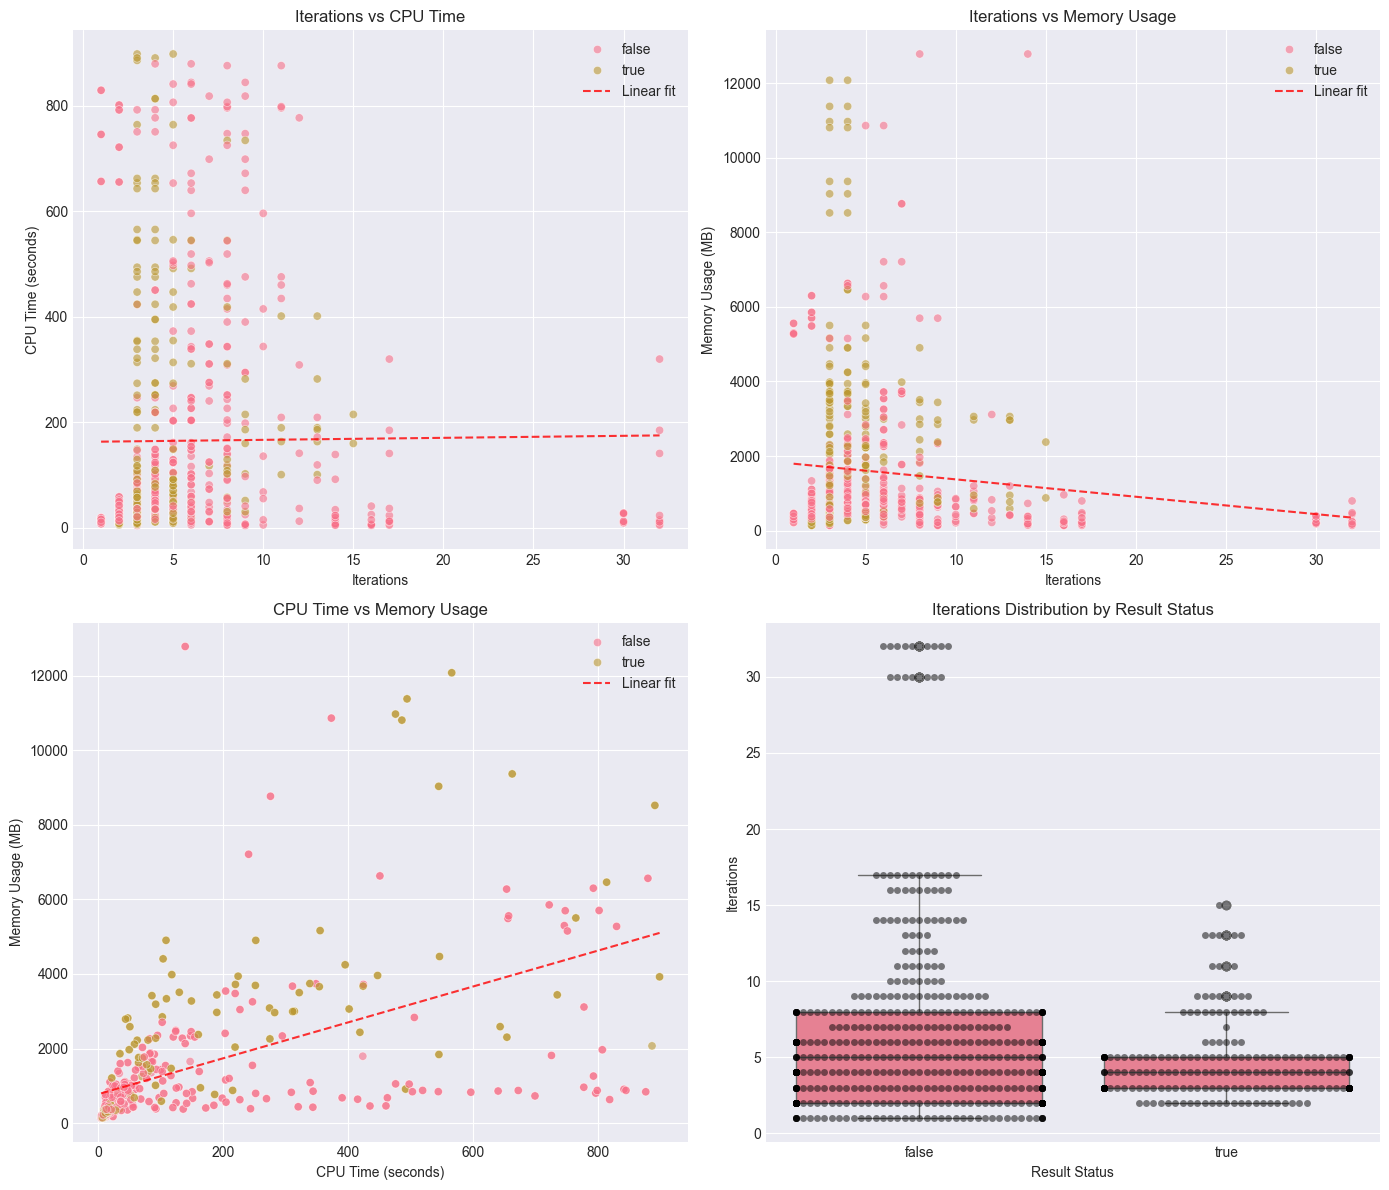

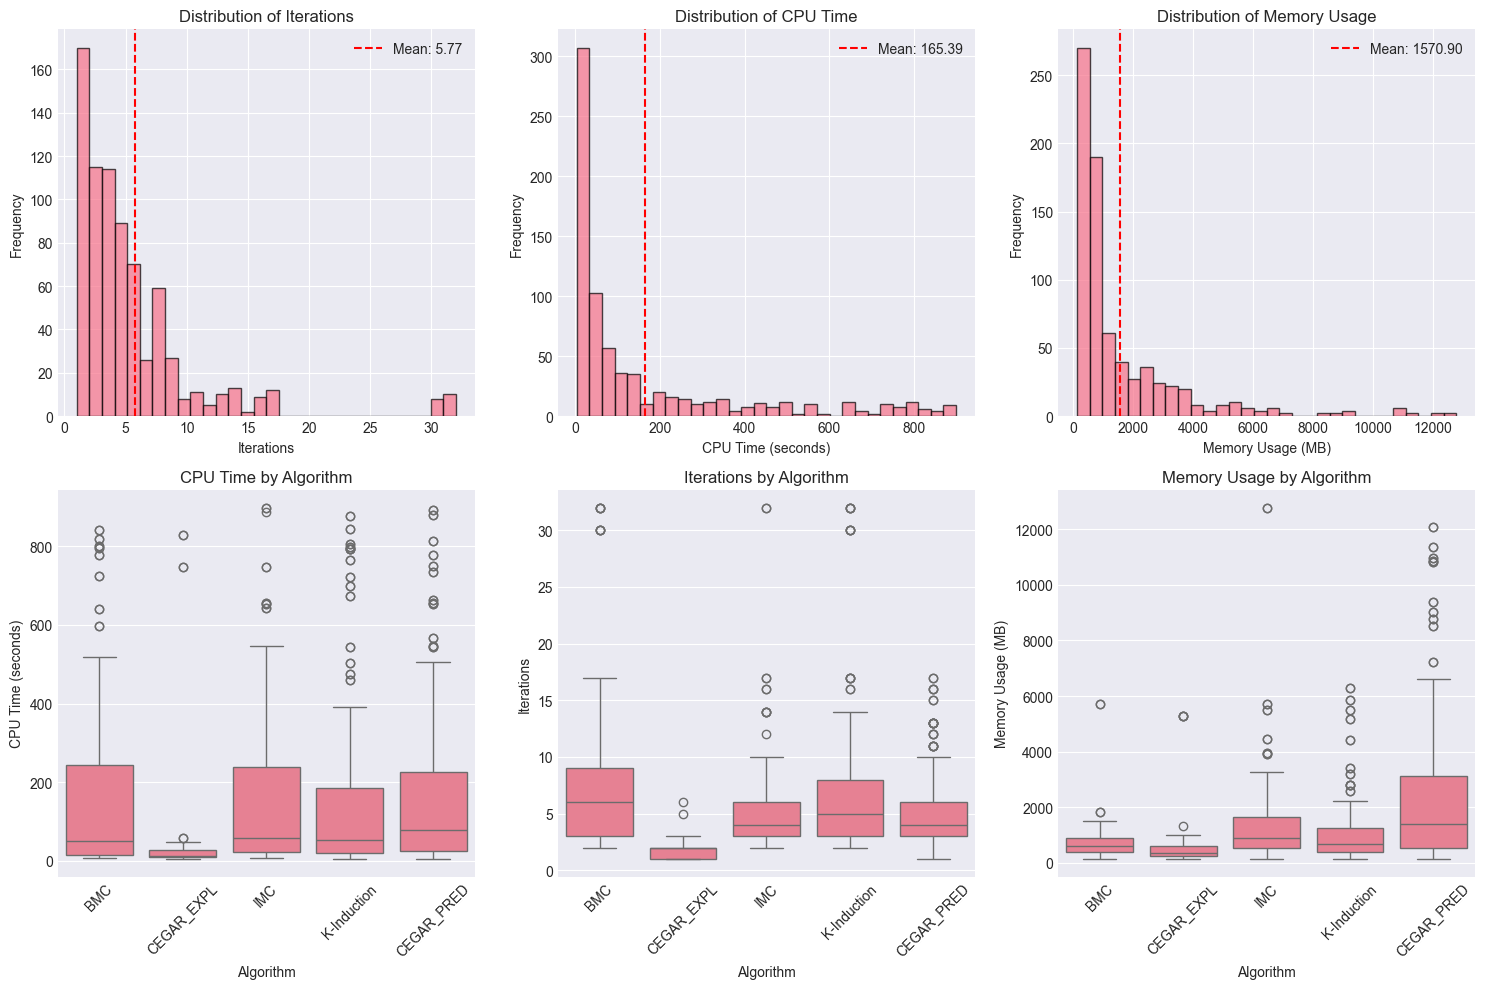

=== STATISTICAL TESTS BETWEEN RESULT GROUPS ===

True results: 215 samples
False results: 543 samples

--- Iterations ---
T-test: t-statistic = -4.9907, p-value = 0.000001
Mann-Whitney U test: U-statistic = 53417.5000, p-value = 0.066214
Cohen's d (effect size): -0.3384
True mean: 4.66, False mean: 6.21

--- CPU_Seconds ---
T-test: t-statistic = 2.1743, p-value = 0.030277
Mann-Whitney U test: U-statistic = 67209.0000, p-value = 0.001147
Cohen's d (effect size): 0.1753
True mean: 194.20, False mean: 153.98

--- Memory_MB ---
T-test: t-statistic = 6.5694, p-value = 0.000000
Mann-Whitney U test: U-statistic = 76745.0000, p-value = 0.000000
Cohen's d (effect size): 0.5749
True mean: 2462.91, False mean: 1217.72
=== ALGORITHM-SPECIFIC ANALYSIS ===

Algorithm: BMC
Number of samples: 113
  Iterations vs CPU Time correlation: -0.0706
  Iterations vs Memory correlation: -0.3190
  CPU Time vs Memory correlation: 0.4463
  Result distribution: {'false': np.int64(113)}

Algorithm: CEGAR_EXPL
Number

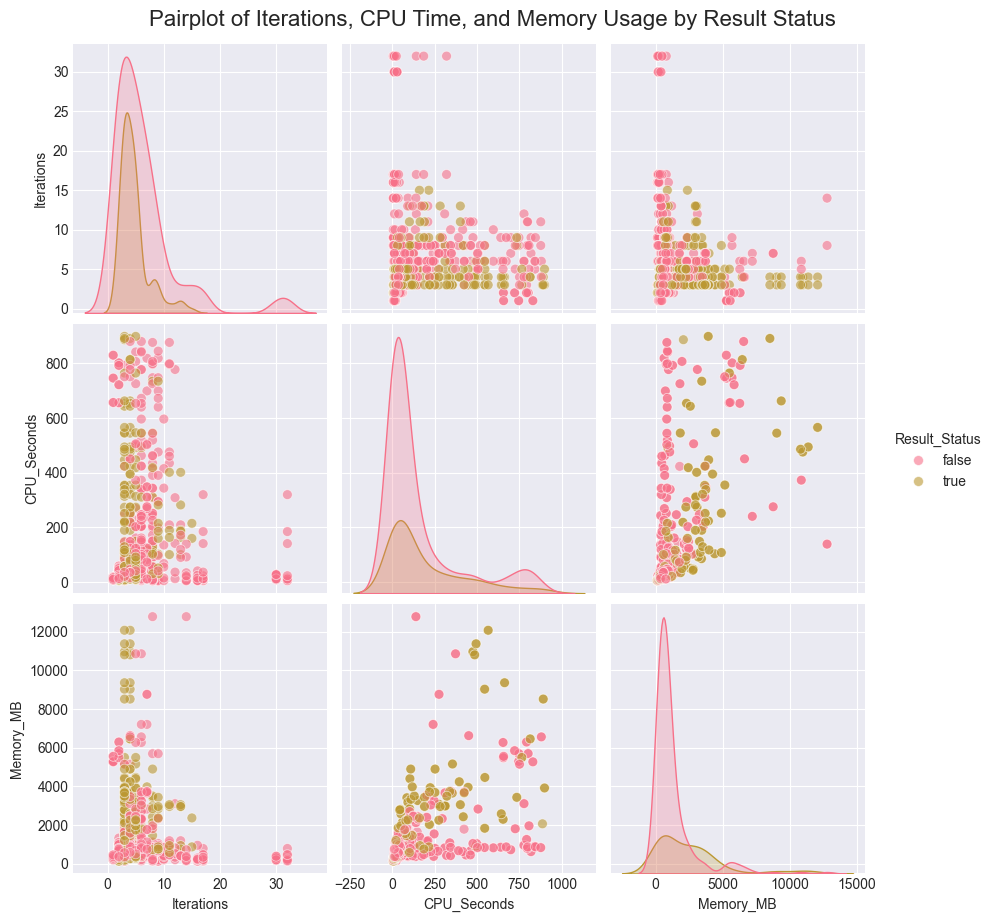

=== SUMMARY OF KEY FINDINGS ===
                                      Metric         Value         Interpretation
Overall Correlation - Iterations vs CPU Time        0.0087 Weak or no correlation
  Overall Correlation - Iterations vs Memory       -0.1203 Weak or no correlation
    Overall Correlation - CPU Time vs Memory        0.5427      Moderate positive
   Mean Iterations Difference (True - False)         -1.55       Higher for false
     Mean CPU Time Difference (True - False) 40.21 seconds        Higher for true
       Mean Memory Difference (True - False)    1245.19 MB        Higher for true
=== COMPREHENSIVE ANALYSIS REPORT ===

1. DATA OVERVIEW:
   - Total merged records: 758
   - Unique algorithms: 5
   - Result distribution: {'false': 543, 'true': 215}

2. KEY CORRELATIONS:
   - Iterations vs CPU Time: 0.0087 (Pearson)
   - Iterations vs Memory: -0.1203 (Pearson)
   - CPU Time vs Memory: 0.5427 (Pearson)

3. INTERPRETATION GUIDELINES:
   - Correlation > 0.7: Strong positive 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load the datasets
print("Loading datasets...")
iterations_df = pd.read_csv('data/log_analysis_iterations.csv')
results_df = pd.read_csv('data/successful_runs_w_results.csv')

print(f"Iterations dataset shape: {iterations_df.shape}")
print(f"Results dataset shape: {results_df.shape}")
print("\nFirst few rows of iterations dataset:")
print(iterations_df.head())
print("\nFirst few rows of results dataset:")
print(results_df.head())

# Data Cleaning and Preparation

# Clean column names
results_df.columns = results_df.columns.str.strip()
iterations_df.columns = iterations_df.columns.str.strip()

# Extract result status (true/false) from the Result column
def extract_result_status(result_str):
    if pd.isna(result_str):
        return None
    result_str = str(result_str).lower()
    if 'false' in result_str:
        return 'false'
    elif 'true' in result_str:
        return 'true'
    return None

results_df['Result_Status'] = results_df['Result'].apply(extract_result_status)

# Extract numeric values from CPU Time and Memory columns
def extract_cpu_seconds(cpu_str):
    if pd.isna(cpu_str):
        return None
    cpu_str = str(cpu_str).lower().replace('s', '')
    try:
        return float(cpu_str)
    except:
        return None

def extract_memory_bytes(mem_str):
    if pd.isna(mem_str):
        return None
    mem_str = str(mem_str).upper()
    if 'KB' in mem_str:
        return float(mem_str.replace('KB', '')) * 1024
    elif 'MB' in mem_str:
        return float(mem_str.replace('MB', '')) * 1024 * 1024
    elif 'GB' in mem_str:
        return float(mem_str.replace('GB', '')) * 1024 * 1024 * 1024
    elif 'B' in mem_str:
        return float(mem_str.replace('B', ''))
    return None

results_df['CPU_Seconds'] = results_df['CPU Time'].apply(extract_cpu_seconds)
results_df['Memory_Bytes'] = results_df['Memory'].apply(extract_memory_bytes)
results_df['Memory_MB'] = results_df['Memory_Bytes'] / (1024 * 1024)

# Rename columns to avoid conflicts before merging
iterations_df = iterations_df.rename(columns={
    'Input Filename': 'Filename',
    'Input Type': 'Input_Type',
    'Algorithm': 'Algorithm'
})

results_df = results_df.rename(columns={
    'Input Type': 'Input_Type',
    'Algorithm': 'Algorithm'
})

# Create a common key for merging
iterations_df['key'] = iterations_df.apply(lambda x: f"{x['Filename']}_{x['Algorithm']}", axis=1)
results_df['key'] = results_df.apply(lambda x: f"{x['Filename']}_{x['Algorithm']}", axis=1)

# Merge datasets
merged_df = pd.merge(iterations_df, results_df, 
                     on='key',
                     how='inner',
                     suffixes=('', '_res'))

print(f"Merged dataset shape: {merged_df.shape}")
print("\nFirst few rows of merged dataset:")
print(merged_df.head())
# Clean up merged dataset - remove duplicate columns
# Identify and drop duplicate columns
cols_to_drop = []
for col in merged_df.columns:
    if col.endswith('_res') and col.replace('_res', '') in merged_df.columns:
        cols_to_drop.append(col)

merged_df = merged_df.drop(columns=cols_to_drop)

# Also drop the duplicate 'key' column if it exists twice
if 'key_res' in merged_df.columns:
    merged_df = merged_df.drop(columns=['key_res'])

print(f"\nAvailable columns after cleanup:")
print(merged_df.columns.tolist())
print(f"\nMerged dataset shape after cleanup: {merged_df.shape}")

# Basic Statistics
print("=== BASIC STATISTICS ===")
print(f"\nNumber of unique algorithms: {merged_df['Algorithm'].nunique()}")
print(f"Unique algorithms: {merged_df['Algorithm'].unique()}")

print(f"\nNumber of unique results: {merged_df['Result_Status'].nunique()}")
print(f"Result distribution:")
print(merged_df['Result_Status'].value_counts())

print(f"\nIterations statistics:")
print(merged_df['Iterations'].describe())

print(f"\nCPU Time statistics (seconds):")
print(merged_df['CPU_Seconds'].describe())

print(f"\nMemory usage statistics (MB):")
print(merged_df['Memory_MB'].describe())


# Correlation Analysis
print("=== CORRELATION ANALYSIS ===")

# Select only numeric columns for correlation
numeric_cols = ['Iterations', 'CPU_Seconds', 'Memory_MB']
correlation_df = merged_df[numeric_cols].copy()

# Calculate correlation matrix
corr_matrix = correlation_df.corr(method='pearson')
print("\nPearson Correlation Matrix:")
print(corr_matrix)

# Calculate Spearman correlation (non-parametric)
spearman_corr = correlation_df.corr(method='spearman')
print("\nSpearman Correlation Matrix:")
print(spearman_corr)

# Statistical significance of correlations
print("\nStatistical significance (p-values) for Pearson correlations:")
for i, col1 in enumerate(numeric_cols):
    for j, col2 in enumerate(numeric_cols):
        if i < j:  # Avoid duplicates and self-correlations
            valid_data = correlation_df[[col1, col2]].dropna()
            if len(valid_data) > 2:
                corr, p_value = stats.pearsonr(valid_data[col1], valid_data[col2])
                print(f"{col1} vs {col2}: p-value = {p_value:.6f}")

# Visualization 1: Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap between Iterations, CPU Time, and Memory Usage')
plt.tight_layout()
plt.show()

# Visualization 2: Scatter plots with regression lines
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Iterations vs CPU Time
ax1 = axes[0, 0]
sns.scatterplot(data=merged_df, x='Iterations', y='CPU_Seconds', hue='Result_Status', 
                alpha=0.6, ax=ax1)
if len(merged_df) > 1:
    z = np.polyfit(merged_df['Iterations'].dropna(), merged_df['CPU_Seconds'].dropna(), 1)
    p = np.poly1d(z)
    ax1.plot(merged_df['Iterations'].sort_values(), p(merged_df['Iterations'].sort_values()), 
             "r--", alpha=0.8, label=f'Linear fit')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('CPU Time (seconds)')
ax1.set_title('Iterations vs CPU Time')
ax1.legend()

# Iterations vs Memory Usage
ax2 = axes[0, 1]
sns.scatterplot(data=merged_df, x='Iterations', y='Memory_MB', hue='Result_Status', 
                alpha=0.6, ax=ax2)
if len(merged_df) > 1:
    z = np.polyfit(merged_df['Iterations'].dropna(), merged_df['Memory_MB'].dropna(), 1)
    p = np.poly1d(z)
    ax2.plot(merged_df['Iterations'].sort_values(), p(merged_df['Iterations'].sort_values()), 
             "r--", alpha=0.8, label=f'Linear fit')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Memory Usage (MB)')
ax2.set_title('Iterations vs Memory Usage')
ax2.legend()

# CPU Time vs Memory Usage
ax3 = axes[1, 0]
sns.scatterplot(data=merged_df, x='CPU_Seconds', y='Memory_MB', hue='Result_Status', 
                alpha=0.6, ax=ax3)
if len(merged_df) > 1:
    z = np.polyfit(merged_df['CPU_Seconds'].dropna(), merged_df['Memory_MB'].dropna(), 1)
    p = np.poly1d(z)
    ax3.plot(merged_df['CPU_Seconds'].sort_values(), p(merged_df['CPU_Seconds'].sort_values()), 
             "r--", alpha=0.8, label=f'Linear fit')
ax3.set_xlabel('CPU Time (seconds)')
ax3.set_ylabel('Memory Usage (MB)')
ax3.set_title('CPU Time vs Memory Usage')
ax3.legend()

# Box plot of iterations by result
ax4 = axes[1, 1]
sns.boxplot(data=merged_df, x='Result_Status', y='Iterations', ax=ax4)
sns.swarmplot(data=merged_df, x='Result_Status', y='Iterations', color='black', alpha=0.5, ax=ax4)
ax4.set_xlabel('Result Status')
ax4.set_ylabel('Iterations')
ax4.set_title('Iterations Distribution by Result Status')

plt.tight_layout()
plt.show()

# Visualization 3: Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Histogram of iterations
axes[0, 0].hist(merged_df['Iterations'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Iterations')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Iterations')
axes[0, 0].axvline(merged_df['Iterations'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {merged_df["Iterations"].mean():.2f}')
axes[0, 0].legend()

# Histogram of CPU time
axes[0, 1].hist(merged_df['CPU_Seconds'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('CPU Time (seconds)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of CPU Time')
axes[0, 1].axvline(merged_df['CPU_Seconds'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {merged_df["CPU_Seconds"].mean():.2f}')
axes[0, 1].legend()

# Histogram of memory usage
axes[0, 2].hist(merged_df['Memory_MB'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Memory Usage (MB)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution of Memory Usage')
axes[0, 2].axvline(merged_df['Memory_MB'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {merged_df["Memory_MB"].mean():.2f}')
axes[0, 2].legend()

# Box plot of CPU time by algorithm
algorithms_to_show = merged_df['Algorithm'].value_counts().head(10).index
filtered_df = merged_df[merged_df['Algorithm'].isin(algorithms_to_show)]
sns.boxplot(data=filtered_df, x='Algorithm', y='CPU_Seconds', ax=axes[1, 0])
axes[1, 0].set_xlabel('Algorithm')
axes[1, 0].set_ylabel('CPU Time (seconds)')
axes[1, 0].set_title('CPU Time by Algorithm')
axes[1, 0].tick_params(axis='x', rotation=45)

# Box plot of iterations by algorithm
sns.boxplot(data=filtered_df, x='Algorithm', y='Iterations', ax=axes[1, 1])
axes[1, 1].set_xlabel('Algorithm')
axes[1, 1].set_ylabel('Iterations')
axes[1, 1].set_title('Iterations by Algorithm')
axes[1, 1].tick_params(axis='x', rotation=45)

# Box plot of memory by algorithm
sns.boxplot(data=filtered_df, x='Algorithm', y='Memory_MB', ax=axes[1, 2])
axes[1, 2].set_xlabel('Algorithm')
axes[1, 2].set_ylabel('Memory Usage (MB)')
axes[1, 2].set_title('Memory Usage by Algorithm')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistical tests between groups

print("=== STATISTICAL TESTS BETWEEN RESULT GROUPS ===")

# Separate data by result status
true_results = merged_df[merged_df['Result_Status'] == 'true']
false_results = merged_df[merged_df['Result_Status'] == 'false']

print(f"\nTrue results: {len(true_results)} samples")
print(f"False results: {len(false_results)} samples")

# Perform t-tests if we have enough samples
for metric in ['Iterations', 'CPU_Seconds', 'Memory_MB']:
    print(f"\n--- {metric} ---")
    true_vals = true_results[metric].dropna()
    false_vals = false_results[metric].dropna()
    
    if len(true_vals) > 1 and len(false_vals) > 1:
        # T-test
        t_stat, p_value = stats.ttest_ind(true_vals, false_vals, equal_var=False)
        print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.6f}")
        
        # Mann-Whitney U test (non-parametric)
        u_stat, u_p_value = stats.mannwhitneyu(true_vals, false_vals)
        print(f"Mann-Whitney U test: U-statistic = {u_stat:.4f}, p-value = {u_p_value:.6f}")
        
        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt((true_vals.std()**2 + false_vals.std()**2) / 2)
        cohens_d = (true_vals.mean() - false_vals.mean()) / pooled_std
        print(f"Cohen's d (effect size): {cohens_d:.4f}")
        
        print(f"True mean: {true_vals.mean():.2f}, False mean: {false_vals.mean():.2f}")
    else:
        print(f"Not enough samples for statistical tests")

# Advanced Analysis: Algorithm-specific correlations

print("=== ALGORITHM-SPECIFIC ANALYSIS ===")

# Analyze correlations for each algorithm separately
algorithms = merged_df['Algorithm'].unique()

for algo in algorithms:
    algo_data = merged_df[merged_df['Algorithm'] == algo]
    if len(algo_data) > 5:  # Only analyze if we have enough samples
        print(f"\nAlgorithm: {algo}")
        print(f"Number of samples: {len(algo_data)}")
        
        # Calculate correlations
        corr_iter_cpu = algo_data['Iterations'].corr(algo_data['CPU_Seconds'])
        corr_iter_mem = algo_data['Iterations'].corr(algo_data['Memory_MB'])
        corr_cpu_mem = algo_data['CPU_Seconds'].corr(algo_data['Memory_MB'])
        
        print(f"  Iterations vs CPU Time correlation: {corr_iter_cpu:.4f}")
        print(f"  Iterations vs Memory correlation: {corr_iter_mem:.4f}")
        print(f"  CPU Time vs Memory correlation: {corr_cpu_mem:.4f}")
        
        # Result distribution
        result_counts = algo_data['Result_Status'].value_counts()
        print(f"  Result distribution: {dict(result_counts)}")

# Visualization 4: Pairplot for comprehensive view
print("Generating pairplot (this may take a moment for large datasets)...")

# Select a subset for pairplot if dataset is large
if len(merged_df) > 1000:
    plot_df = merged_df.sample(1000, random_state=42)
else:
    plot_df = merged_df

# Create pairplot
g = sns.pairplot(plot_df, 
                 vars=['Iterations', 'CPU_Seconds', 'Memory_MB'],
                 hue='Result_Status',
                 diag_kind='kde',
                 plot_kws={'alpha': 0.6, 's': 50},
                 height=3)
g.fig.suptitle('Pairplot of Iterations, CPU Time, and Memory Usage by Result Status', 
               y=1.02, fontsize=16)
plt.show()

# Summary table of key findings
print("=== SUMMARY OF KEY FINDINGS ===")

summary_data = []

# Overall correlations
corr_iter_cpu = merged_df['Iterations'].corr(merged_df['CPU_Seconds'])
corr_iter_mem = merged_df['Iterations'].corr(merged_df['Memory_MB'])
corr_cpu_mem = merged_df['CPU_Seconds'].corr(merged_df['Memory_MB'])

summary_data.append({
    'Metric': 'Overall Correlation - Iterations vs CPU Time',
    'Value': f"{corr_iter_cpu:.4f}",
    'Interpretation': 'Strong positive' if abs(corr_iter_cpu) > 0.7 else 
                     'Moderate positive' if abs(corr_iter_cpu) > 0.3 else 
                     'Weak or no correlation'
})

summary_data.append({
    'Metric': 'Overall Correlation - Iterations vs Memory',
    'Value': f"{corr_iter_mem:.4f}",
    'Interpretation': 'Strong positive' if abs(corr_iter_mem) > 0.7 else 
                     'Moderate positive' if abs(corr_iter_mem) > 0.3 else 
                     'Weak or no correlation'
})

summary_data.append({
    'Metric': 'Overall Correlation - CPU Time vs Memory',
    'Value': f"{corr_cpu_mem:.4f}",
    'Interpretation': 'Strong positive' if abs(corr_cpu_mem) > 0.7 else 
                     'Moderate positive' if abs(corr_cpu_mem) > 0.3 else 
                     'Weak or no correlation'
})

# Compare means between true and false results
if len(true_results) > 0 and len(false_results) > 0:
    iter_diff = true_results['Iterations'].mean() - false_results['Iterations'].mean()
    cpu_diff = true_results['CPU_Seconds'].mean() - false_results['CPU_Seconds'].mean()
    mem_diff = true_results['Memory_MB'].mean() - false_results['Memory_MB'].mean()
    
    summary_data.append({
        'Metric': 'Mean Iterations Difference (True - False)',
        'Value': f"{iter_diff:.2f}",
        'Interpretation': 'Higher for true' if iter_diff > 0 else 'Higher for false' if iter_diff < 0 else 'Equal'
    })
    
    summary_data.append({
        'Metric': 'Mean CPU Time Difference (True - False)',
        'Value': f"{cpu_diff:.2f} seconds",
        'Interpretation': 'Higher for true' if cpu_diff > 0 else 'Higher for false' if cpu_diff < 0 else 'Equal'
    })
    
    summary_data.append({
        'Metric': 'Mean Memory Difference (True - False)',
        'Value': f"{mem_diff:.2f} MB",
        'Interpretation': 'Higher for true' if mem_diff > 0 else 'Higher for false' if mem_diff < 0 else 'Equal'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Final comprehensive report
print("=== COMPREHENSIVE ANALYSIS REPORT ===")
print("\n1. DATA OVERVIEW:")
print(f"   - Total merged records: {len(merged_df)}")
print(f"   - Unique algorithms: {merged_df['Algorithm'].nunique()}")
print(f"   - Result distribution: {merged_df['Result_Status'].value_counts().to_dict()}")

print("\n2. KEY CORRELATIONS:")
print(f"   - Iterations vs CPU Time: {corr_iter_cpu:.4f} (Pearson)")
print(f"   - Iterations vs Memory: {corr_iter_mem:.4f} (Pearson)")
print(f"   - CPU Time vs Memory: {corr_cpu_mem:.4f} (Pearson)")

print("\n3. INTERPRETATION GUIDELINES:")
print("   - Correlation > 0.7: Strong positive relationship")
print("   - Correlation 0.3-0.7: Moderate positive relationship")
print("   - Correlation < 0.3: Weak or no relationship")
print("   - Negative values indicate inverse relationships")

print("\n4. RECOMMENDATIONS FOR FURTHER ANALYSIS:")
print("   - Investigate algorithm-specific patterns")
print("   - Consider non-linear relationships")
print("   - Analyze outliers that don't follow general trends")
print("   - Look at time complexity patterns for different algorithms")